# Predict Climatology

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
from scipy.interpolate import griddata

## Data

### distance to coastline

Raw data downloaded at 0.01 degree resolution from https://oceancolor.gsfc.nasa.gov/docs/distfromcoast/. Downsampled to 0.5 degree resolution in QGIS using `gdalwarp` (`average` method).

In [2]:
dist_to_coast_nc = Dataset('data/distance-to-coast.nc')
dist_to_coast_nc.variables.keys()

odict_keys(['Band1', 'crs', 'lat', 'lon'])

In [3]:
print('latitude  shape : {}'.format(np.shape(dist_to_coast_nc.variables['lat'][:].data)[0]))
print('longitude shape : {}'.format(np.shape(dist_to_coast_nc.variables['lon'][:].data)[0]))

latitude  shape : 360
longitude shape : 720


In [4]:
lon = dist_to_coast_nc.variables['lon'][:].data
lat = dist_to_coast_nc.variables['lat'][:].data
dist_to_coast = dist_to_coast_nc.variables['Band1'][:,:].data

dist_to_coast = -dist_to_coast

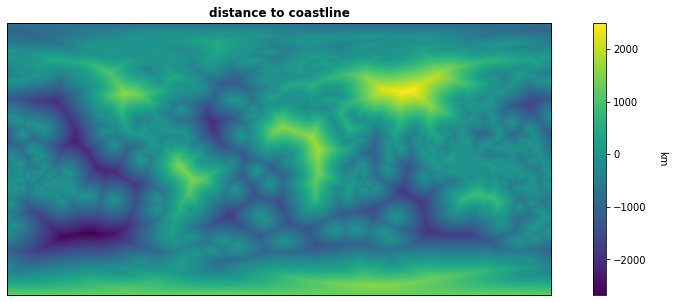

In [5]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

im = ax.pcolormesh(lon,
                   lat,
                   dist_to_coast,
                   transform=ccrs.PlateCarree(), cmap='viridis')

ax.set_title('distance to coastline', fontweight='bold')
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('km', rotation=270, labelpad=20)

plt.show(fig)

### elevation

Raw data from the Shuttle Radar Topography Mission (SRTM, https://www2.jpl.nasa.gov/srtm/). Downsampled to 0.5 degree resolution in QGIS using `gdalwarp` (`average` method).

In [6]:
elevation_nc = Dataset('data/elevation.nc')
elevation_nc.variables.keys()

odict_keys(['Band1', 'lat', 'lon'])

In [7]:
print('latitude  shape : {}'.format(np.shape(elevation_nc.variables['lat'][:].data)[0]))
print('longitude shape : {}'.format(np.shape(elevation_nc.variables['lon'][:].data)[0]))

latitude  shape : 360
longitude shape : 720


In [8]:
elevation = elevation_nc.variables['Band1'][:,:].data

elevation[elevation>1e35] = np.nan

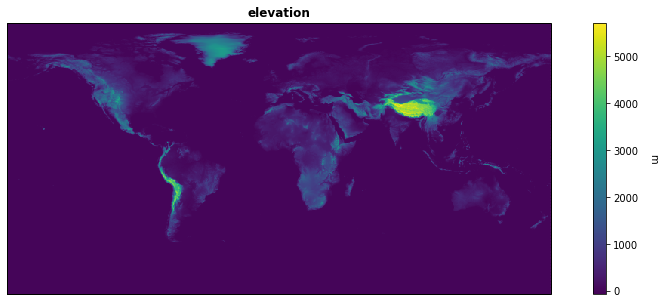

In [9]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

im = ax.pcolormesh(lon,
                   lat,
                   elevation,
                   transform=ccrs.PlateCarree(), cmap='viridis')

ax.set_title('elevation', fontweight='bold')
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('m', rotation=270, labelpad=20)

plt.show(fig)

### temperature and runoff

Raw data from ERA5-Land (https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview), taking the 'soil temperature level 1' and 'runoff' variables.

We need to downsample this data, as well as take the time averaged mean.

Grid setup in the raw data is described here: https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference

In [10]:
# if set to true, perform the time averaging, interpolation, and save results to a .netcdf
# if false, just read in a previously time averaged and interpolated .netcdf
refresh = False

In [11]:
if refresh:
    # note that this file is IGNORED in this repository, due to its large size
    temp_runoff_nc = Dataset('data/temp-runoff.nc')
    temp_runoff_nc.variables.keys()

In [12]:
if refresh:
    temp_raw = temp_runoff_nc.variables['stl1'][:,:,:].data
    runoff_raw = temp_runoff_nc.variables['ro'][:,:,:].data

    temp_raw[temp_raw<-30000] = np.nan
    runoff_raw[runoff_raw<-30000] = np.nan

Plot just the first time slice:

In [13]:
if refresh:
    fig = plt.figure(figsize=(15,5))

    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

    im = ax.pcolormesh(temp_runoff_nc.variables['longitude'][:].data,
                       temp_runoff_nc.variables['latitude'][:].data,
                       temp_raw[0,:,:],
                       transform=ccrs.PlateCarree(), cmap='viridis')

    ax.set_title('temperature', fontweight='bold')
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('K', rotation=270, labelpad=20)

    plt.show(fig)

In [14]:
if refresh:
    fig = plt.figure(figsize=(15,5))

    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

    im = ax.pcolormesh(temp_runoff_nc.variables['longitude'][:].data,
                       temp_runoff_nc.variables['latitude'][:].data,
                       runoff_raw[0,:,:],
                       transform=ccrs.PlateCarree(), cmap='viridis')

    ax.set_title('runoff', fontweight='bold')
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('m', rotation=270, labelpad=20)

    plt.show(fig)

In [15]:
if refresh:
    # average over time
    temp_raw_mean = np.nanmean(temp_raw, axis=0)
    runoff_raw_mean = np.nanmean(runoff_raw, axis=0)

In [16]:
if refresh:
    # wrap around 180 instead of 0
    ERA_lon = temp_runoff_nc.variables['longitude'][:].data

    wrap_ind = np.int(len(ERA_lon)/2)

    ERA_lon_wrap = np.concatenate([ERA_lon[wrap_ind:],ERA_lon[:wrap_ind]])
    ERA_lon_wrap[ERA_lon_wrap>=180] = ERA_lon_wrap[ERA_lon_wrap>=180]-360

    temp_raw_mean_wrap = np.concatenate([temp_raw_mean[:,wrap_ind:],temp_raw_mean[:,:wrap_ind]],1)
    runoff_raw_mean_wrap = np.concatenate([runoff_raw_mean[:,wrap_ind:],runoff_raw_mean[:,:wrap_ind]],1)

In [17]:
if refresh:
    # set up the grid
    ERA_xx, ERA_yy = np.meshgrid(ERA_lon_wrap,
                                 temp_runoff_nc.variables['latitude'][:].data)

    ERA_xx = np.ravel(ERA_xx)
    ERA_yy = np.ravel(ERA_yy)

    xx, yy = np.meshgrid(lon, lat)

    # interpolate
    temp = griddata(points=(ERA_xx, ERA_yy),
                    values=np.ravel(temp_raw_mean_wrap),
                    xi=(xx, yy),
                    method ='linear')

    runoff = griddata(points=(ERA_xx, ERA_yy),
                      values=np.ravel(runoff_raw_mean_wrap),
                      xi=(xx, yy),
                      method ='linear')

In [18]:
if refresh:
    # initialize netCDF
    temp_nc = Dataset('data/temp.nc', 'w', format='NETCDF4')
    temp_nc.description = 'ERA5-Land temperature data, time averaged and interpolated.'

    # create dimensions
    temp_nc.createDimension('lon', 720)
    temp_nc.createDimension('lat', 360)

    # initialize variables
    lon_var = temp_nc.createVariable('lon', 'f', ('lon',))
    lat_var = temp_nc.createVariable('lat', 'f', ('lat',))
    tmp_var = temp_nc.createVariable('tmp', 'f', ('lat','lon',), fill_value=1e36)

    # attributes
    lon_var.long_name = 'longitude'
    lat_var.long_name = 'latitude'
    tmp_var.long_name = 'temperature'

    lon_var.units = 'degrees'
    lat_var.units = 'degrees'
    tmp_var.units = 'K'

    lon_var.axis = 'X'
    lat_var.axis = 'Y'

    # fill variables
    lon_var[:] = lon
    lat_var[:] = lat

    temp_masked = temp.copy()
    temp_masked[np.isnan(temp_masked)] = 1e36
    tmp_var[:,:] = temp_masked

    temp_nc.close()

In [19]:
if refresh:
    # initialize netCDF
    runoff_nc = Dataset('data/runoff.nc', 'w', format='NETCDF4')
    runoff_nc.description = 'ERA5-Land runoff data, time averaged and interpolated.'

    # create dimensions
    runoff_nc.createDimension('lon', 720)
    runoff_nc.createDimension('lat', 360)

    # initialize variables
    lon_var = runoff_nc.createVariable('lon', 'f', ('lon',))
    lat_var = runoff_nc.createVariable('lat', 'f', ('lat',))
    rnf_var = runoff_nc.createVariable('rnf', 'f', ('lat','lon',), fill_value=1e36)

    # attributes
    lon_var.long_name = 'longitude'
    lat_var.long_name = 'latitude'
    rnf_var.long_name = 'runoff'

    lon_var.units = 'degrees'
    lat_var.units = 'degrees'
    rnf_var.units = 'm'

    lon_var.axis = 'X'
    lat_var.axis = 'Y'

    # fill variables
    lon_var[:] = lon
    lat_var[:] = lat

    runoff_masked = runoff.copy()
    runoff_masked[np.isnan(runoff_masked)] = 1e36
    rnf_var[:,:] = runoff_masked

    runoff_nc.close()

In [20]:
if refresh==False:
    temp_nc = Dataset('data/temp.nc')
    runoff_nc = Dataset('data/runoff.nc')
    
    temp = temp_nc.variables['tmp'][:,:].data
    runoff = runoff_nc.variables['rnf'][:,:].data

    temp[temp>1e35] = np.nan
    runoff[runoff>1e35] = np.nan

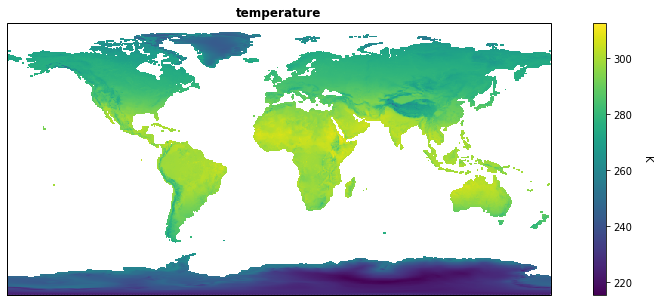

In [21]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

im = ax.pcolormesh(lon,
                   lat,
                   temp,
                   transform=ccrs.PlateCarree(), cmap='viridis')

ax.set_title('temperature', fontweight='bold')
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('K', rotation=270, labelpad=20)

plt.show(fig)

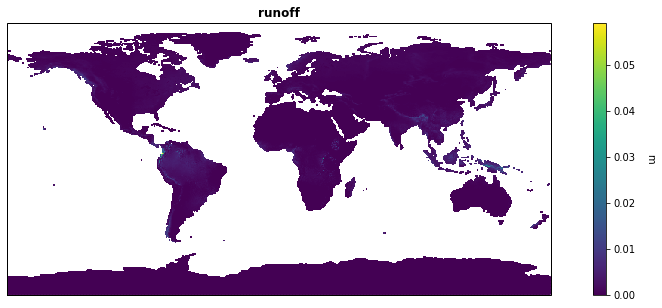

In [22]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

im = ax.pcolormesh(lon,
                   lat,
                   runoff,
                   transform=ccrs.PlateCarree(), cmap='viridis')

ax.set_title('runoff', fontweight='bold')
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('m', rotation=270, labelpad=20)

plt.show(fig)

### distance from western and eastern shorelines